# First glance on TSLA stock

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np

start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2019, 1, 1)

df = web.DataReader("TSLA", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,314.500000,295.200012,313.500000,295.390015,5559900,295.390015
2018-12-26,326.970001,294.089996,300.000000,326.089996,8163100,326.089996
2018-12-27,322.170013,301.500000,319.839996,316.130005,8575100,316.130005
2018-12-28,336.239990,318.410004,323.100006,333.869995,9939000,333.869995
2018-12-31,339.209991,325.260010,337.790009,332.799988,6302300,332.799988


In [2]:
# calculate moving average
window = 100
close_px = df['Adj Close']
mavg = close_px.rolling(window=window).mean()

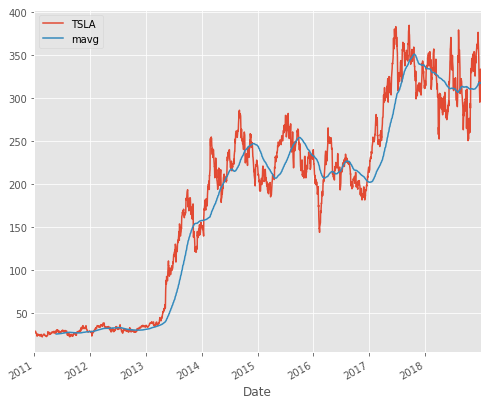

In [3]:
# initial plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.legend()

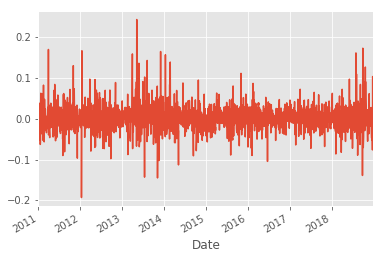

In [4]:
# find expected returns
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

# Analyze other stocks

In [5]:
# read in data
dfcomp = web.DataReader(['AAPL', 'GOOG', 'AMZN', 'FB', 'MSFT'], 'yahoo', start=start, end=end)['Adj Close']
dfcomp.head()

Symbols,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,
2011-01-03,41.088589,184.220001,NaN,301.046600,22.558224
2011-01-04,41.303032,185.009995,NaN,299.935760,22.646908
2011-01-05,41.640896,187.419998,NaN,303.397797,22.574345
2011-01-06,41.607231,185.860001,NaN,305.604523,23.235449
2011-01-07,41.905193,185.490005,NaN,307.069031,23.058081


In [6]:
# correlation analysis
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
corr

Symbols,AAPL,AMZN,FB,GOOG,MSFT
Symbols,,,,,
AAPL,1.000000,0.364971,0.264430,0.433988,0.426584
AMZN,0.364971,1.000000,0.381560,0.549114,0.471289
FB,0.264430,0.381560,1.000000,0.399040,0.292865
GOOG,0.433988,0.549114,0.399040,1.000000,0.536333
MSFT,0.426584,0.471289,0.292865,0.536333,1.000000


Text(0, 0.5, 'Returns MSFT')

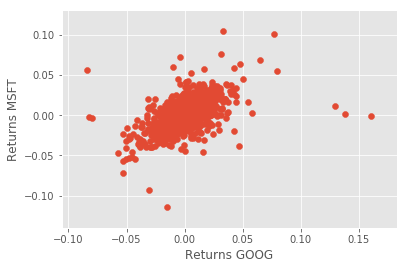

In [7]:
# plot scatter return of GOOG and MSFT
plt.scatter(retscomp.GOOG, retscomp.MSFT)
plt.xlabel('Returns GOOG')
plt.ylabel('Returns MSFT')

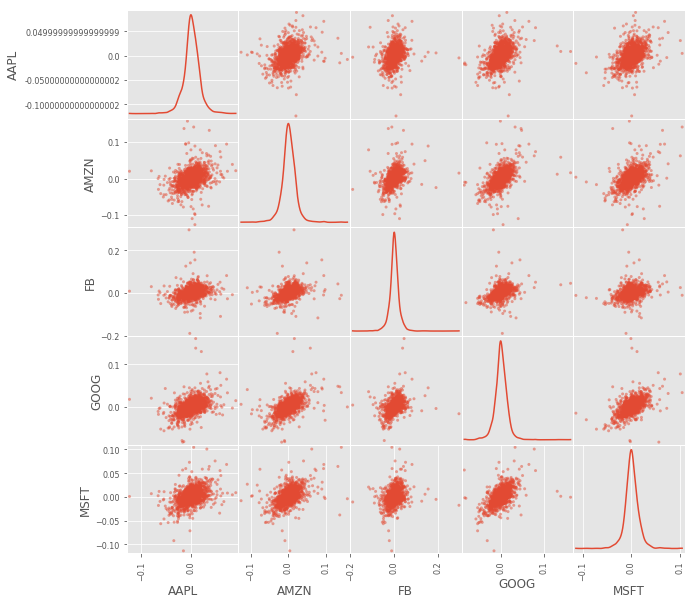

In [8]:
# plot scatter matrix
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

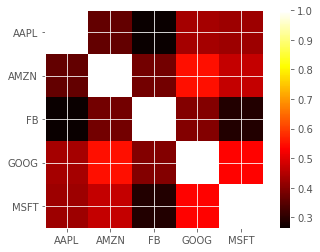

In [9]:
# heat map visualization
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

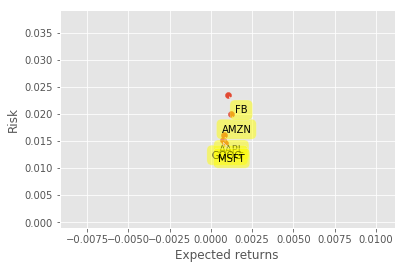

In [10]:
# plot return rates and risks
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(label, xy=(x,y), xytext=(20,-20), textcoords='offset points', ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='yellow',alpha=0.5), arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Predicting stock price

This workbook will use three machine learning algorithms to analize the stocks:
- Simple Linear Analysis
- Quadratic Discriminant Analysis (QDA)
- K-Nearest Neighbor (KNN)

## Feature Engineering
First of all, the features in our dataframe should be adjusted a bit. Let's add more features - High Low Percentage and Percentage Change.

In [11]:
dfreg = df.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.00
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2018-12-24,295.390015,5559900,6.533731,-5.776710
2018-12-26,326.089996,8163100,10.083108,8.696665
2018-12-27,316.130005,8575100,6.538454,-1.159952
2018-12-28,333.869995,9939000,5.340398,3.333330
2018-12-31,332.799988,6302300,4.191701,-1.477255


In [12]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# Drop missing values
dfreg = dfreg.fillna(value=-99999)

# Separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating label
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# scale the feature matrix X
X = preprocessing.scale(X)

# get train and test set
X_late = X[-forecast_out:]
X = X[:-forecast_out]
y = dfreg['label'][:-forecast_out]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1891, 4)
(100, 4)
(1891,)
(100,)


## Start prediction!
As mentioned before, this workbook will give three examples of machine learning predictions. This part will give you more detail about it.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [15]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [16]:
# Evaluate
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("Linear Regression: ", confidencereg)
print("Quadratic Regression 2: ", confidencepoly2)
print("Quadratic Regression 3: ", confidencepoly3)
print("KNN Regression: ", confidenceknn)

Linear Regression:  -0.7649084428446868
Quadratic Regression 2:  -0.6590173929351142
Quadratic Regression 3:  -0.6212922914645211
KNN Regression:  -2.1069372651009144


The scores look not that good. Let's see what do they predict comparing to the real numbers.

In [17]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,314.500000,295.200012,313.500000,295.390015,5559900,295.390015
2018-12-26,326.970001,294.089996,300.000000,326.089996,8163100,326.089996
2018-12-27,322.170013,301.500000,319.839996,316.130005,8575100,316.130005
2018-12-28,336.239990,318.410004,323.100006,333.869995,9939000,333.869995
2018-12-31,339.209991,325.260010,337.790009,332.799988,6302300,332.799988


In [18]:
last_date = dfreg.iloc[-1].name

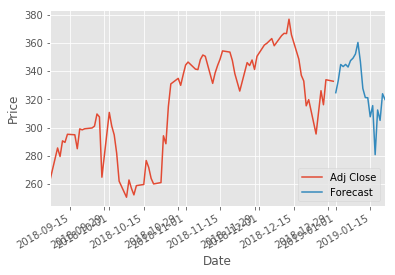

In [25]:
forecast_set = clfpoly2.predict(X_late)
dfreg['Forecast'] = np.nan



last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(100).plot()
dfreg['Forecast'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()